In [271]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

df_prescribers = pd.read_csv("pa2017.csv", dtype={'NPI': str})  # 1 row per dr
df_drugs = pd.read_csv("padrugs2017.csv", dtype={'NPI': str})  # 1 row per dr/drug
df_opioids = pd.read_csv("druggeographypa.csv", dtype={'Gnrc_Name': str})  # classify

df_drugs = df_drugs.merge(df_opioids, on="Gnrc_Name", how="left")  # Add opioid classification to drug data
df_opioids_only = df_drugs[df_drugs["Opioid_Drug_Flag"] == 'Y']  # Keep only opioid drugs

In [2]:
codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")
print(codes.columns)
df_opioids = codes[codes["pharmclas"].str.contains("opioid agonist", case=False, na=False)]
opioid_ndcs = df_opioids[["ndc"]].drop_duplicates()
opioid_ndcs.to_csv("opioid_ndcs.csv", index=False)
print("Opioid NDCs extracted and saved as 'opioid_ndcs.csv'")

Index(['prodid', 'ndc', 'prodtype', 'propname', 'propsuf', 'npropname',
       'dosename', 'routename', 'stmarkdatestr', 'stmarkdate',
       'endmarkdatestr', 'endmarkdate', 'markname', 'appnum', 'labelname',
       'subname', 'actnumstr', 'actingunit', 'pharmclas', 'deasched',
       'ndc_exclude_flag', 'listing_record_certstr', 'listing_record_cert'],
      dtype='object')
Opioid NDCs extracted and saved as 'opioid_ndcs.csv'


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1712877063.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  codes = pd.read_csv("codes.csv", dtype={'NPI': str}, encoding="ISO-8859-1")


In [3]:
df_opioids_agg = df_opioids_only.groupby("Prscrbr_NPI").agg(
    Total_Opioid_Claims=("Tot_Clms_x", "sum"),  # Total opioid prescriptions per doctor
    Unique_Opioid_Drugs=("Gnrc_Name", "nunique")  # Number of distinct opioids prescribed
).reset_index()

df_merged = pd.merge(df_prescribers, df_opioids_agg, on="Prscrbr_NPI", how="left")
df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
df_merged["Unique_Opioid_Drugs"].fillna(0, inplace=True)

df_specialty_stats = df_merged.groupby("Prscrbr_Type")["Total_Opioid_Claims"].agg(['mean', 'std']).reset_index()
df_specialty_stats.rename(columns={'mean': 'Specialty_Mean_Opioid_Claims', 'std': 'Specialty_Std_Opioid_Claims'}, inplace=True)

df_merged = pd.merge(df_merged, df_specialty_stats, on="Prscrbr_Type", how="left")

df_merged["Opioid_Prescribing_ZScore"] = (df_merged["Total_Opioid_Claims"] - df_merged["Specialty_Mean_Opioid_Claims"]) / df_merged["Specialty_Std_Opioid_Claims"]
df_merged.to_csv("pa_merged_opioid_specialty_adjusted.csv", index=False)


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1131647889.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["Total_Opioid_Claims"].fillna(0, inplace=True)
/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1131647889.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [235]:
df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str}) 
df_opioid_ndcs = pd.read_csv("opioid_ndcs.csv", dtype=str)
opioid_ndc_set = set(df_opioid_ndcs["ndc"].astype(str).str.strip())
def is_opioid_payment(row):
    for i in range(1, 6):  
        ndc = str(row.get(f"Associated_Drug_or_Biological_NDC_{i}", "")) 
        if any(opioid_ndc in ndc for opioid_ndc in opioid_ndc_set):  
            return True
    return False
df_payments["Is_Opioid_Payment"] = df_payments.apply(is_opioid_payment, axis=1)
df_opioid_payments = df_payments[df_payments["Is_Opioid_Payment"]]
df_opioid_payments.to_csv("opioid_payments_filtered.csv", index=False)
print("Filtered Open Payments data saved as 'opioid_payments_filtered.csv'")

/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/2791430706.py:1: DtypeWarning: Columns (4,10,15,32,33,34,35,51,53,54,69,75,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_payments = pd.read_csv("generalpaymentspa.csv", dtype={'covered_recipient_npi': str})


Filtered Open Payments data saved as 'opioid_payments_filtered.csv'


In [272]:
df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})
df_network = df_opioid_payments.groupby(["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Covered_Recipient_NPI"]).agg(
    Total_Opioid_Payments=("Total_Amount_of_Payment_USDollars", "sum")
).reset_index()
df_network.to_csv("pharma_prescriber_network_data.csv", index=False)
print("Aggregated network data saved as 'pharma_prescriber_network_data.csv'")

Aggregated network data saved as 'pharma_prescriber_network_data.csv'


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/171572685.py:1: DtypeWarning: Columns (4,35,51,54,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_opioid_payments = pd.read_csv("opioid_payments_filtered.csv", dtype={'covered_recipient_npi': str})


In [273]:
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={'covered_recipient_NPI': str})
G = nx.DiGraph()
pharma_nodes = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
prescriber_nodes = df_network["Covered_Recipient_NPI"].unique()
G.add_nodes_from(pharma_nodes, bipartite=0)  # Group 0: Pharma companies
G.add_nodes_from(prescriber_nodes, bipartite=1)  # Group 1: Prescribers
for _, row in df_network.iterrows():
    G.add_edge(row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"], 
               row["Covered_Recipient_NPI"], 
               weight=row["Total_Opioid_Payments"])
nx.write_gml(G, "pharma_prescriber_network.gml")
print("Network constructed and saved as 'pharma_prescriber_network.gml'")

Network constructed and saved as 'pharma_prescriber_network.gml'


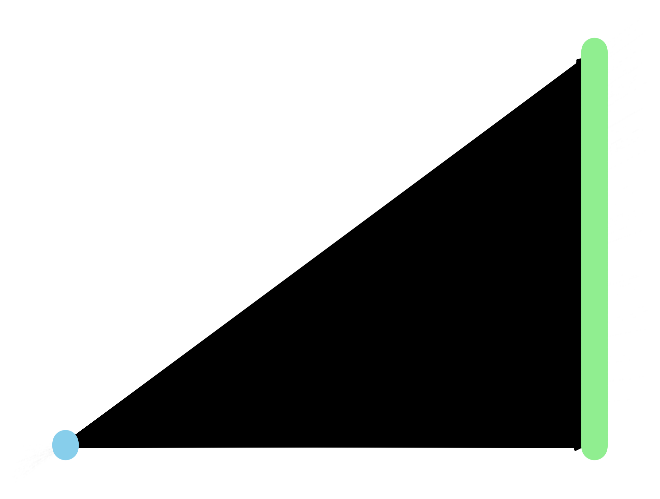

Total pharmaceutical companies: 24
Total doctors: 2026


In [274]:
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

left_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
right_nodes = set(G) - left_nodes
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(left_nodes))
pos.update((n, (2, i)) for i, n in enumerate(right_nodes))
nx.draw(G, pos, with_labels=False, node_color=['skyblue' if n in left_nodes else 'lightgreen' for n in G.nodes()])
plt.show()

pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}

print(f"Total pharmaceutical companies: {len(pharma_nodes)}")
print(f"Total doctors: {len(doctor_nodes)}")

In [275]:
pharma_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 0}
centrality = bipartite.degree_centrality(G, pharma_nodes)
pharma_centrality = {n: c for n, c in centrality.items() if n in pharma_nodes}
for node, centrality_score in pharma_centrality.items():
    print(f"{node}: {centrality_score:.4f}")
unweighted_degree = dict(G.degree(pharma_nodes))
for node in pharma_nodes:
    print(f"{node}: {unweighted_degree[node]:,.2f}")

Mallinckrodt LLC: 0.0010
INSYS Therapeutics Inc: 0.0997
The Medicines Company: 0.0138
Daiichi Sankyo Inc.: 0.1037
Collegium Pharmaceutical, Inc.: 0.1422
BioDelivery Sciences International, Inc.: 0.0647
Mylan Institutional Inc.: 0.0039
Egalet US Inc: 0.0582
Purdue Pharma L.P.: 0.4768
Akrimax Pharmaceuticals, LLC: 0.0064
Pernix Therapeutics Holdings, Inc.: 0.1022
Purdue Transdermal Technologies L.P.: 0.0005
Endo Pharmaceuticals Inc.: 0.0015
PFIZER INC.: 0.0933
Mission Pharmacal Company: 0.0104
Indivior Inc.: 0.1624
Depomed, Inc.: 0.2878
Orexo US, Inc.: 0.0582
Mylan Specialty L.P.: 0.0227
Braeburn Pharmaceuticals, Inc.: 0.0395
Vertical Pharmaceuticals, LLC: 0.0370
Fresenius Kabi USA, LLC: 0.0005
Mylan Pharmaceuticals Inc.: 0.0123
Sentynl Therapeutics, Inc.: 0.0311
Mallinckrodt LLC: 2.00
The Medicines Company: 28.00
Daiichi Sankyo Inc.: 210.00
Collegium Pharmaceutical, Inc.: 288.00
Pernix Therapeutics Holdings, Inc.: 207.00
Purdue Transdermal Technologies L.P.: 1.00
Endo Pharmaceuticals In

In [276]:
doctor_nodes = {n for n, d in G.nodes(data=True) if d.get("bipartite") == 1}
centrality = bipartite.degree_centrality(G, doctor_nodes)
doctor_centrality = {n: c for n, c in centrality.items() if n in doctor_nodes}
df = pd.DataFrame.from_dict(doctor_centrality, orient='index', columns=['degree_centrality'])
df.index.name = 'doctor_id' 
df.to_csv("doctor_degree_centrality.csv")

In [277]:
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)
pharma_hubs = {n: h for n, h in hubs.items() if G.nodes[n].get("bipartite") == 0}
doctor_authorities = {n: a for n, a in authorities.items() if G.nodes[n].get("bipartite") == 1}
pharma_df = pd.DataFrame.from_dict(pharma_hubs, orient='index', columns=['hub_score'])
pharma_df.index.name = 'pharma_company'
pharma_df.to_csv("pharma_hub_scores.csv")
doctor_df = pd.DataFrame.from_dict(doctor_authorities, orient='index', columns=['authority_score'])
doctor_df.index.name = 'doctor_id'
doctor_df.to_csv("doctor_authority_scores.csv")

In [278]:
import os
import pyproj
os.environ["PROJ_DATA"] = "/opt/homebrew/share/proj"
pyproj.datadir.set_data_dir(os.environ["PROJ_DATA"])

df_zips = pd.read_csv("generalpaymentspa.csv", dtype={"Covered_Recipient_NPI": str, "Recipient_Zip_Code": str})
df_zips["Recipient_Zip_Code"] = df_zips["Recipient_Zip_Code"].str[:5].str.zfill(5)
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()
doctor_ids_in_G = {
    str(n).split(".")[0].strip().zfill(10)
    for n, d in G.nodes(data=True)
    if d.get("bipartite") == 1
}



/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/3065994609.py:6: DtypeWarning: Columns (4,10,32,33,34,35,51,53,54,69,75,77,78,79,80,81,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zips = pd.read_csv("generalpaymentspa.csv", dtype={"Covered_Recipient_NPI": str, "Recipient_Zip_Code": str})


In [ ]:
df_payments["Covered_Recipient_NPI"] = (
    df_payments["Covered_Recipient_NPI"]
    .astype(str)
    .str.strip()
    .str.split(".").str[0]
    .str.zfill(10)
)

df_payments["Recipient_Zip_Code"] = (
    df_payments["Recipient_Zip_Code"]
    .astype(str)
    .str.strip()
    .str[:5]
    .str.zfill(5)
)

df_zips = df_payments[df_payments["Covered_Recipient_NPI"].isin(doctor_ids_in_G)]
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()

df_zips = df_zips.rename(columns={
    "Covered_Recipient_NPI": "doctor_id",
    "Recipient_Zip_Code": "zip"
})

print("Matched ZIP rows:", df_zips.shape)
print("Sample matched ZIPs:", df_zips['zip'].unique()[:5])


✅ Matched ZIP rows: (3385, 2)
Sample matched ZIPs: ['19030' '19115' '18344' '17403' '17112']


In [ ]:
df_payments["Covered_Recipient_NPI"] = df_payments["Covered_Recipient_NPI"].astype(str).str.strip().str.zfill(10)
df_payments["Recipient_Zip_Code"] = df_payments["Recipient_Zip_Code"].astype(str).str[:5].str.zfill(5)

df_zips = df_payments[df_payments["Covered_Recipient_NPI"].isin(doctor_ids_in_G)]
df_zips = df_zips[["Covered_Recipient_NPI", "Recipient_Zip_Code"]].drop_duplicates()
df_zips = df_zips.rename(columns={"Covered_Recipient_NPI": "doctor_id", "Recipient_Zip_Code": "zip"})

print("Matched ZIP rows:", df_zips.shape)
print("Sample matched ZIPs:", df_zips['zip'].unique()[:5])


✅ Matched ZIP rows: (3385, 2)
Sample matched ZIPs: ['19030' '19115' '18344' '17403' '17112']


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1712899590.py:48: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1712899590.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


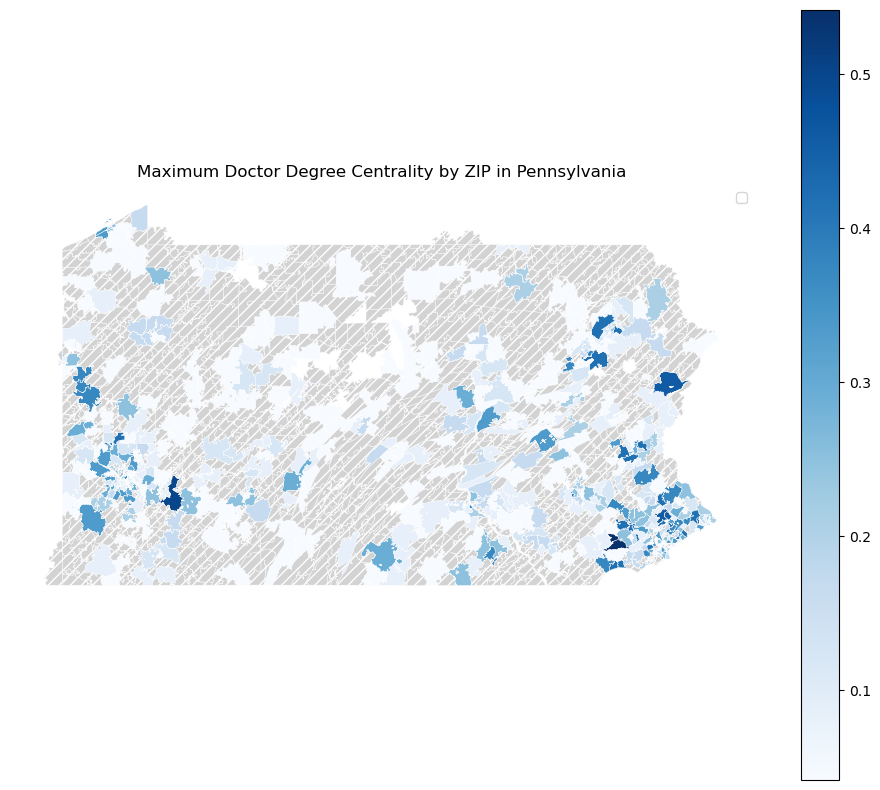

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

zip_shapes = gpd.read_file("pa_zip_shapefile.shp")
zip_shapes = zip_shapes.rename(columns={"ZCTA5CE": "zip"})
zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)

df_centrality = pd.read_csv("doctor_degree_centrality.csv", dtype=str)
df_centrality["doctor_id"] = df_centrality["doctor_id"].str.split(".").str[0].str.zfill(10)

df_joined = pd.merge(df_centrality, df_zips, on="doctor_id", how="inner")
df_joined["degree_centrality"] = df_joined["degree_centrality"].astype(float)

df_by_zip = df_joined.groupby("zip").agg(
    max_centrality=("degree_centrality", "max"),
    doctor_count=("doctor_id", "count")
).reset_index()

df_by_zip["zip"] = df_by_zip["zip"].astype(str).str.zfill(5)
merged = zip_shapes.merge(df_by_zip, on="zip", how="left")

fig, ax = plt.subplots(figsize=(12, 10))

merged.plot(
    column="max_centrality",
    cmap="Blues",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Maximum Doctor Degree Centrality by ZIP in Pennsylvania")
plt.axis("off")
plt.legend()
fig.savefig("doctor_degree_centrality_map.jpg", dpi=300, bbox_inches="tight", format="jpg")
plt.show()



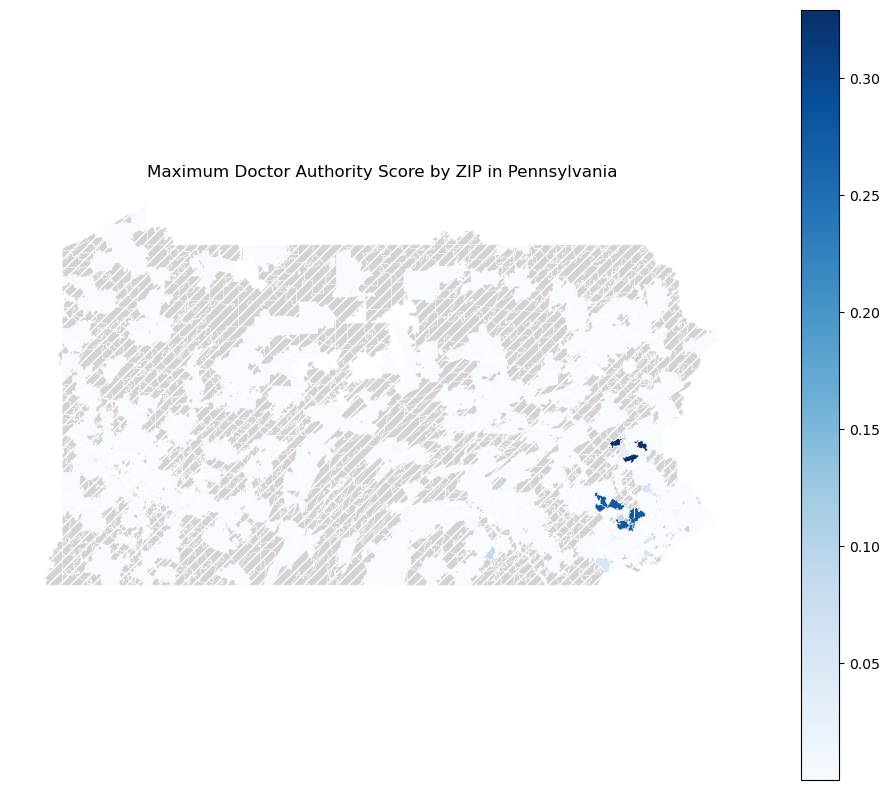

In [282]:

df_authority = pd.read_csv("doctor_authority_scores.csv", dtype={"doctor_id": str})
df_authority["doctor_id"] = df_authority["doctor_id"].str.split(".").str[0].str.zfill(10)
df_authority["authority_score"] = df_authority["authority_score"].astype(float)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str).str.strip().str.zfill(10)
df_joined_auth = pd.merge(df_authority, df_zips, on="doctor_id", how="inner")
df_by_zip_auth = df_joined_auth.groupby("zip").agg(
    max_authority=("authority_score", "max"),
    doctor_count=("doctor_id", "count")
).reset_index()
zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)
df_by_zip_auth["zip"] = df_by_zip_auth["zip"].astype(str).str.zfill(5)
merged_auth = zip_shapes.merge(df_by_zip_auth, on="zip", how="left")
fig, ax = plt.subplots(figsize=(12, 10))
merged_auth.plot(
    column="max_authority",
    cmap="Blues",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Maximum Doctor Authority Score by ZIP in Pennsylvania")
plt.axis("off")

fig.savefig("doctor_simple_authority_map.jpg", dpi=300, bbox_inches="tight", format="jpg")
plt.show()




In [283]:

top_zip_max_auth = df_by_zip_auth.sort_values("max_authority", ascending=False)
print(top_zip_max_auth[["zip", "max_authority", "doctor_count"]].head())

       zip  max_authority  doctor_count
348  18017       0.329150            22
365  18078       0.329150             1
368  18103       0.329150            29
582  19460       0.276301            21
593  19518       0.276301             1


In [284]:
import pandas as pd

max_auth_idx = df_joined_auth.groupby("zip")["authority_score"].idxmax()
top_doctors_by_zip = df_joined_auth.loc[max_auth_idx, ["zip", "doctor_id", "authority_score"]]
top_doctors_by_zip = top_doctors_by_zip.sort_values("authority_score", ascending=False)
df_names = pd.read_csv("generalpaymentspa.csv", dtype=str)
df_names["Covered_Recipient_NPI"] = df_names["Covered_Recipient_NPI"].astype(str).str.strip().str.zfill(10)
top_doctors_by_zip["doctor_id"] = top_doctors_by_zip["doctor_id"].astype(str).str.strip().str.zfill(10)
top_doctors_named = pd.merge(
    top_doctors_by_zip,
    df_names[["Covered_Recipient_NPI", "Covered_Recipient_First_Name", "Covered_Recipient_Last_Name"]],
    left_on="doctor_id",
    right_on="Covered_Recipient_NPI",
    how="left"
).drop_duplicates(subset=["doctor_id", "zip"])
top_doctors_named = top_doctors_named[["zip", "doctor_id", "authority_score", "Covered_Recipient_First_Name", "Covered_Recipient_Last_Name"]]
top_doctors_named = top_doctors_named.sort_values("authority_score", ascending=False)
top_doctors_named.to_csv("top_authority_doctors_by_zip.csv", index=False)


In [285]:
from scipy.sparse.linalg import svds

df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})
companies = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
doctors = df_network["Covered_Recipient_NPI"].unique()
company_to_idx = {name: i for i, name in enumerate(companies)}
doctor_to_idx = {npi: j for j, npi in enumerate(doctors)}
W = np.zeros((len(companies), len(doctors)))
for _, row in df_network.iterrows():
    i = company_to_idx[row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"]]
    j = doctor_to_idx[row["Covered_Recipient_NPI"]]
    W[i, j] = row["Total_Opioid_Payments"]
Dx = np.diag(W.sum(axis=1))
Dy = np.diag(W.sum(axis=0))
Dx_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=1), 1e-10)))
Dy_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=0), 1e-10)))
W_hat = Dx_inv_sqrt @ W @ Dy_inv_sqrt
u, s, vt = svds(W_hat, k=2)
x_hat = u[:, -1]  
y_hat = vt.T[:, -1] 
x = Dx_inv_sqrt @ x_hat
y = Dy_inv_sqrt @ y_hat
cx = np.median(x)
cy = np.median(y)
A = [companies[i] for i in range(len(x)) if x[i] >= cx]
Ac = [companies[i] for i in range(len(x)) if x[i] < cx]
B = [doctors[j] for j in range(len(y)) if y[j] >= cy]
Bc = [doctors[j] for j in range(len(y)) if y[j] < cy]

print("Partition A (pharma):", A[:5])
print("Partition B (doctors):", B[:5])

Partition A (pharma): ['Akrimax Pharmaceuticals, LLC', 'Collegium Pharmaceutical, Inc.', 'Endo Pharmaceuticals Inc.', 'Fresenius Kabi USA, LLC', 'INSYS Therapeutics Inc']
Partition B (doctors): ['1023245883.0', '1144267790.0', '1194731547.0', '1275505919.0', '1316042591.0']


In [286]:
partition_A_indices = np.where(x >= cx)[0]
partition_Ac_indices = np.where(x < cx)[0]
partition_A_companies = [companies[i] for i in partition_A_indices]
partition_Ac_companies = [companies[i] for i in partition_Ac_indices]
print("Number of pharma companies in Partition A:", len(partition_A_companies))
print("Number of pharma companies in Partition Aᶜ:", len(partition_Ac_companies))
print("\nPartition A Companies:")
print(partition_A_companies)
print("\nPartition Aᶜ Companies:")
print(partition_Ac_companies)

Number of pharma companies in Partition A: 12
Number of pharma companies in Partition Aᶜ: 12

Partition A Companies:
['Akrimax Pharmaceuticals, LLC', 'Collegium Pharmaceutical, Inc.', 'Endo Pharmaceuticals Inc.', 'Fresenius Kabi USA, LLC', 'INSYS Therapeutics Inc', 'Mallinckrodt LLC', 'Mission Pharmacal Company', 'Mylan Pharmaceuticals Inc.', 'Mylan Specialty L.P.', 'Pernix Therapeutics Holdings, Inc.', 'Purdue Transdermal Technologies L.P.', 'The Medicines Company']

Partition Aᶜ Companies:
['BioDelivery Sciences International, Inc.', 'Braeburn Pharmaceuticals, Inc.', 'Daiichi Sankyo Inc.', 'Depomed, Inc.', 'Egalet US Inc', 'Indivior Inc.', 'Mylan Institutional Inc.', 'Orexo US, Inc.', 'PFIZER INC.', 'Purdue Pharma L.P.', 'Sentynl Therapeutics, Inc.', 'Vertical Pharmaceuticals, LLC']


In [287]:
import numpy as np
import pandas as pd

cy = np.median(y)
partition_B_indices = np.where(y >= cy)[0]
partition_B_doctors = [doctors[j] for j in partition_B_indices]
partition_Bc_indices = np.where(y < cy)[0]
partition_Bc_doctors = [doctors[j] for j in partition_Bc_indices]
print("Number in Partition B:", len(partition_B_doctors))
print("Number in Partition Bᶜ:", len(partition_Bc_doctors))
df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})
df_partition_B = df_network[df_network["Covered_Recipient_NPI"].isin(partition_B_doctors)]
payments_summary = df_partition_B.groupby("Covered_Recipient_NPI").agg(
    Total_Received=("Total_Opioid_Payments", "sum"),
    Num_Companies=("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "nunique")
).reset_index()
print(payments_summary.head())

Number in Partition B: 1175
Number in Partition Bᶜ: 851
  Covered_Recipient_NPI  Total_Received  Num_Companies
0          1003022500.0          169.20              3
1          1003120213.0          221.76              2
2          1003143280.0           28.53              1
3          1003171141.0           12.75              1
4          1003296245.0           12.22              1


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})

df_network["Company_Total"] = df_network.groupby(
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"
)["Total_Opioid_Payments"].transform("sum")

df_network["Normalized_Weight"] = (
    df_network["Total_Opioid_Payments"] / df_network["Company_Total"]
)

def recursive_partition(df_network, min_group_size=6):
    partitions = [{"name": "root", "companies": df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()}]
    final = []

    while partitions:
        part = partitions.pop(0)
        companies = part["companies"]
        if len(companies) <= min_group_size:
            final.append(part)
            continue

        sub_df = df_network[df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].isin(companies)]
        doctors = sub_df["Covered_Recipient_NPI"].unique()

        company_to_idx = {c: i for i, c in enumerate(companies)}
        doctor_to_idx = {d: j for j, d in enumerate(doctors)}

        W = np.zeros((len(companies), len(doctors)))
        for _, row in sub_df.iterrows():
            i = company_to_idx[row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"]]
            j = doctor_to_idx[row["Covered_Recipient_NPI"]]
            W[i, j] = row["Normalized_Weight"]

        Dx_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=1), 1e-10)))
        Dy_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=0), 1e-10)))
        W_hat = Dx_inv_sqrt @ W @ Dy_inv_sqrt

        u, s, vt = svds(W_hat, k=2)
        x_hat = u[:, -1]
        x = Dx_inv_sqrt @ x_hat
        cx = np.median(x)

        A = [companies[i] for i in range(len(x)) if x[i] >= cx]
        Ac = [companies[i] for i in range(len(x)) if x[i] < cx]

        partitions.append({"name": part["name"] + "_A", "companies": A})
        partitions.append({"name": part["name"] + "_Ac", "companies": Ac})

    return final

final_partitions = recursive_partition(df_network, min_group_size=6)

for p in final_partitions:
    print(f"📦 Partition '{p['name']}' — {len(p['companies'])} companies")
    print(p["companies"])
    print()



📦 Partition 'root_A_Ac' — 6 companies
['Mylan Institutional Inc.', 'Mylan Pharmaceuticals Inc.', 'Mylan Specialty L.P.', 'Orexo US, Inc.', 'PFIZER INC.', 'Vertical Pharmaceuticals, LLC']

📦 Partition 'root_Ac_A' — 6 companies
['Daiichi Sankyo Inc.', 'Egalet US Inc', 'Mallinckrodt LLC', 'Mission Pharmacal Company', 'Purdue Pharma L.P.', 'Sentynl Therapeutics, Inc.']

📦 Partition 'root_Ac_Ac' — 5 companies
['BioDelivery Sciences International, Inc.', 'Braeburn Pharmaceuticals, Inc.', 'Endo Pharmaceuticals Inc.', 'Pernix Therapeutics Holdings, Inc.', 'The Medicines Company']

📦 Partition 'root_A_A_A' — 4 companies
['Akrimax Pharmaceuticals, LLC', 'Depomed, Inc.', 'Indivior Inc.', 'Purdue Transdermal Technologies L.P.']

📦 Partition 'root_A_A_Ac' — 3 companies
['Collegium Pharmaceutical, Inc.', 'Fresenius Kabi USA, LLC', 'INSYS Therapeutics Inc']



In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

df_network = pd.read_csv("pharma_prescriber_network_data.csv", dtype={
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name": str,
    "Covered_Recipient_NPI": str
})

df_network["Company_Total"] = df_network.groupby(
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"
)["Total_Opioid_Payments"].transform("sum")

df_network["Normalized_Weight"] = (
    df_network["Total_Opioid_Payments"] / df_network["Company_Total"]
)

def recursive_partition(df_network, max_clusters=4, exact_group_size=6):
    all_companies = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
    assert len(all_companies) == max_clusters * exact_group_size, "Company count must be divisible evenly"

    partitions = [{"name": "root", "companies": all_companies}]
    final = []

    while partitions:
        part = partitions.pop(0)
        companies = part["companies"]

        if len(final) + len(partitions) + 1 >= max_clusters:
            final.append(part)
            continue

        if len(companies) <= exact_group_size:
            final.append(part)
            continue

        sub_df = df_network[df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].isin(companies)]
        doctors = sub_df["Covered_Recipient_NPI"].unique()

        company_to_idx = {c: i for i, c in enumerate(companies)}
        doctor_to_idx = {d: j for j, d in enumerate(doctors)}

        W = np.zeros((len(companies), len(doctors)))
        for _, row in sub_df.iterrows():
            i = company_to_idx[row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"]]
            j = doctor_to_idx[row["Covered_Recipient_NPI"]]
            W[i, j] = row["Normalized_Weight"]

        Dx_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=1), 1e-10)))
        Dy_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(W.sum(axis=0), 1e-10)))
        W_hat = Dx_inv_sqrt @ W @ Dy_inv_sqrt

        u, s, vt = svds(W_hat, k=2)
        x_hat = u[:, -1]
        x = Dx_inv_sqrt @ x_hat
        cx = np.median(x)

        sorted_indices = np.argsort(x)
        sorted_companies = [companies[i] for i in sorted_indices]

        A = sorted_companies[:exact_group_size]
        Ac = sorted_companies[exact_group_size:]

        if len(A) == 0 or len(Ac) == 0:
            final.append(part)
        else:
            partitions.append({"name": part["name"] + "_A", "companies": A})
            partitions.append({"name": part["name"] + "_Ac", "companies": Ac})

    assert len(final) == max_clusters, f"Expected {max_clusters} clusters, got {len(final)}"
    for p in final:
        assert len(p["companies"]) == exact_group_size, f"Cluster has {len(p['companies'])}, expected {exact_group_size}"

    return final

final_partitions = recursive_partition(df_network, max_clusters=4, exact_group_size=6)

for i, p in enumerate(final_partitions):
    print(f"\n📦 Cluster {i} — '{p['name']}' with {len(p['companies'])} companies:")
    for company in p["companies"]:
        print("   ", company)



📦 Cluster 0 — 'root_A' with 6 companies:
    Mylan Specialty L.P.
    The Medicines Company
    Orexo US, Inc.
    Fresenius Kabi USA, LLC
    Mission Pharmacal Company
    Indivior Inc.

📦 Cluster 1 — 'root_Ac_A' with 6 companies:
    Purdue Transdermal Technologies L.P.
    Endo Pharmaceuticals Inc.
    Mylan Institutional Inc.
    Mylan Pharmaceuticals Inc.
    BioDelivery Sciences International, Inc.
    Sentynl Therapeutics, Inc.

📦 Cluster 2 — 'root_Ac_Ac_A' with 6 companies:
    Braeburn Pharmaceuticals, Inc.
    Egalet US Inc
    Akrimax Pharmaceuticals, LLC
    Vertical Pharmaceuticals, LLC
    Collegium Pharmaceutical, Inc.
    Purdue Pharma L.P.

📦 Cluster 3 — 'root_Ac_Ac_Ac' with 6 companies:
    Daiichi Sankyo Inc.
    Depomed, Inc.
    PFIZER INC.
    Pernix Therapeutics Holdings, Inc.
    INSYS Therapeutics Inc
    Mallinckrodt LLC


In [338]:
print(final_partitions)

[{'name': 'root_A', 'companies': ['Mylan Specialty L.P.', 'The Medicines Company', 'Orexo US, Inc.', 'Fresenius Kabi USA, LLC', 'Mission Pharmacal Company', 'Indivior Inc.']}, {'name': 'root_Ac_A', 'companies': ['Purdue Transdermal Technologies L.P.', 'Endo Pharmaceuticals Inc.', 'Mylan Institutional Inc.', 'Mylan Pharmaceuticals Inc.', 'BioDelivery Sciences International, Inc.', 'Sentynl Therapeutics, Inc.']}, {'name': 'root_Ac_Ac_A', 'companies': ['Braeburn Pharmaceuticals, Inc.', 'Egalet US Inc', 'Akrimax Pharmaceuticals, LLC', 'Vertical Pharmaceuticals, LLC', 'Collegium Pharmaceutical, Inc.', 'Purdue Pharma L.P.']}, {'name': 'root_Ac_Ac_Ac', 'companies': ['Daiichi Sankyo Inc.', 'Depomed, Inc.', 'PFIZER INC.', 'Pernix Therapeutics Holdings, Inc.', 'INSYS Therapeutics Inc', 'Mallinckrodt LLC']}]


In [339]:
for i, partition in enumerate(final_partitions):
    print(f"Cluster {i}: {partition['name']} has {len(partition['companies'])} companies")

Cluster 0: root_A has 6 companies
Cluster 1: root_Ac_A has 6 companies
Cluster 2: root_Ac_Ac_A has 6 companies
Cluster 3: root_Ac_Ac_Ac has 6 companies


In [ ]:
company_to_cluster = {}
for partition in final_partitions:
    for company in partition["companies"]:
        company_to_cluster[company] = partition["name"]

df_network["cluster"] = df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].map(company_to_cluster)
df_network = df_network.dropna(subset=["cluster"])

df_network["Covered_Recipient_NPI"] = (
    df_network["Covered_Recipient_NPI"]
    .astype(str)
    .str.strip()
    .str.split(".").str[0]
    .str.zfill(10)
)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str).str.strip().str.zfill(10)



df_merged = df_network.merge(df_zips, left_on="Covered_Recipient_NPI", right_on="doctor_id", how="left")

df_zip_summary = (
    df_merged.groupby(["zip", "cluster"])["Covered_Recipient_NPI"]
    .nunique()
    .reset_index()
    .rename(columns={"Covered_Recipient_NPI": "doctor_count"})
)

print(df_zip_summary.head())
df_zip_summary.to_csv("doctors_by_zip_and_cluster.csv", index=False)



     zip        cluster  doctor_count
0  01510   root_Ac_Ac_A             1
1  01522   root_Ac_Ac_A             1
2  01801   root_Ac_Ac_A             1
3  01801  root_Ac_Ac_Ac             1
4  08002   root_Ac_Ac_A             1


In [ ]:
df_zip_dominant = (
    df_zip_summary.sort_values(["zip", "doctor_count"], ascending=[True, False])
    .drop_duplicates(subset="zip")
)

/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/2723779623.py:31: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


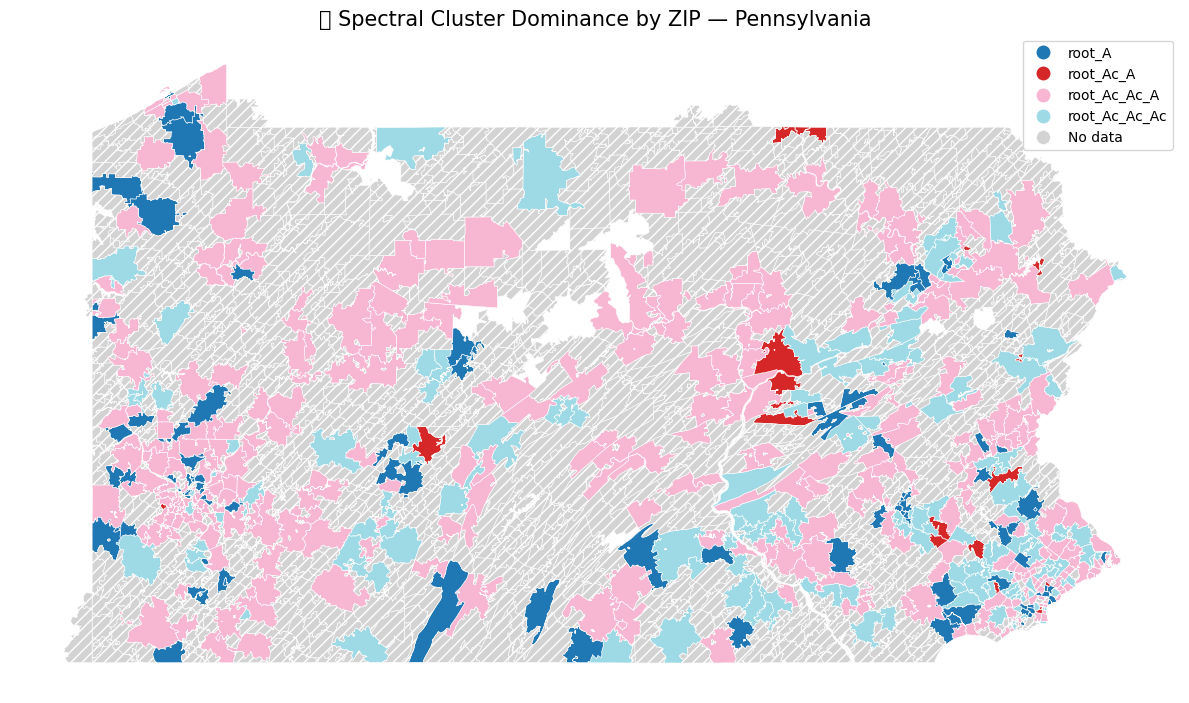

In [ ]:

zip_shapes["zip"] = zip_shapes["zip"].astype(str).str.zfill(5)
df_zip_dominant["zip"] = df_zip_dominant["zip"].astype(str).str.zfill(5)

zip_cluster_map = zip_shapes.merge(df_zip_dominant, on="zip", how="left")

fig, ax = plt.subplots(figsize=(12, 10))

zip_cluster_map.plot(
    column="cluster",
    cmap="tab20",
    linewidth=0.4,
    edgecolor="white",
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("🧬 Spectral Cluster Dominance by ZIP — Pennsylvania", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()


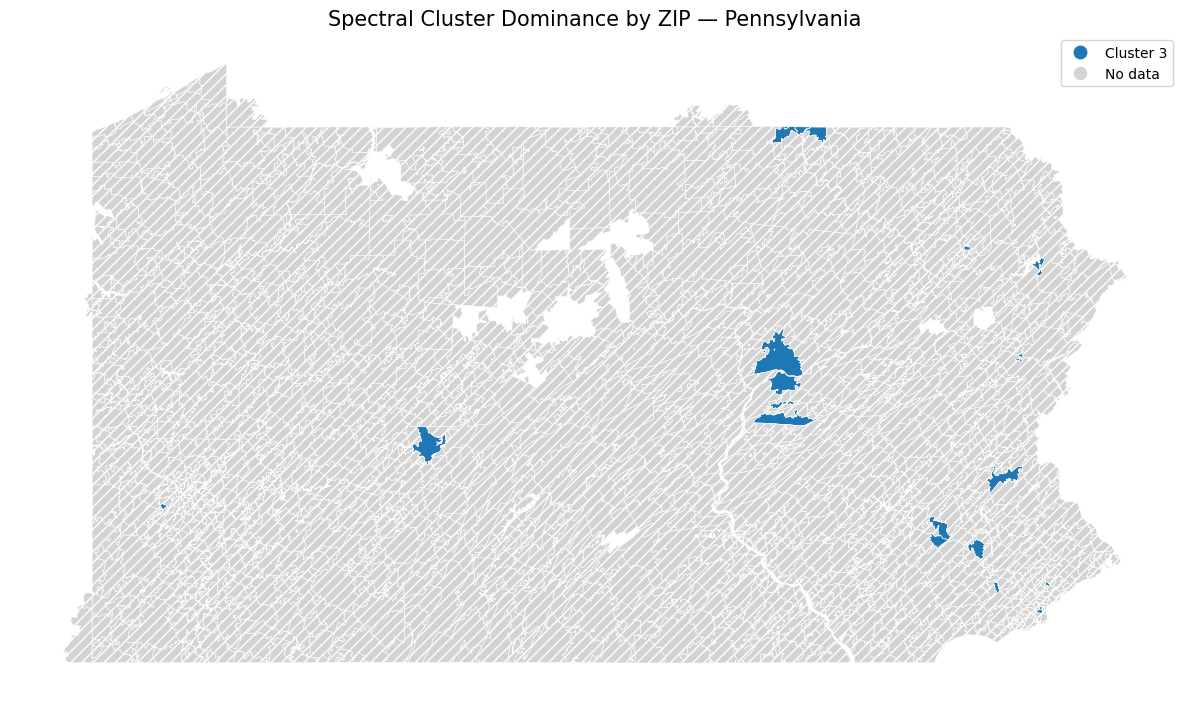

In [ ]:

cluster_name_map = {
    "root_A_A": "Cluster 1",
    "root_A_Ac": "Cluster 2",
    "root_Ac_A": "Cluster 3",
    "root_Ac_Ac": "Cluster 4"
}

df_zip_dominant["clean_cluster"] = df_zip_dominant["cluster"].map(cluster_name_map)

zip_cluster_map = zip_shapes.merge(df_zip_dominant[["zip", "clean_cluster"]], on="zip", how="left")

fig, ax = plt.subplots(figsize=(12, 10))
zip_cluster_map.plot(
    column="clean_cluster",
    cmap="tab10",
    linewidth=0.4,
    edgecolor="white",
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Spectral Cluster Dominance by ZIP — Pennsylvania", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
cluster_company_table = {
    cluster_name_map.get(partition["name"], partition["name"]): partition["companies"]
    for partition in final_partitions
}

cluster_table_df = pd.DataFrame(dict([
    (label, pd.Series(companies)) for label, companies in cluster_company_table.items()
]))

print(cluster_table_df)


                      root_A                                 Cluster 3  \
0       Mylan Specialty L.P.      Purdue Transdermal Technologies L.P.   
1      The Medicines Company                 Endo Pharmaceuticals Inc.   
2             Orexo US, Inc.                  Mylan Institutional Inc.   
3    Fresenius Kabi USA, LLC                Mylan Pharmaceuticals Inc.   
4  Mission Pharmacal Company  BioDelivery Sciences International, Inc.   
5              Indivior Inc.                Sentynl Therapeutics, Inc.   

                     root_Ac_Ac_A                       root_Ac_Ac_Ac  
0  Braeburn Pharmaceuticals, Inc.                 Daiichi Sankyo Inc.  
1                   Egalet US Inc                       Depomed, Inc.  
2    Akrimax Pharmaceuticals, LLC                         PFIZER INC.  
3   Vertical Pharmaceuticals, LLC  Pernix Therapeutics Holdings, Inc.  
4  Collegium Pharmaceutical, Inc.              INSYS Therapeutics Inc  
5              Purdue Pharma L.P.                

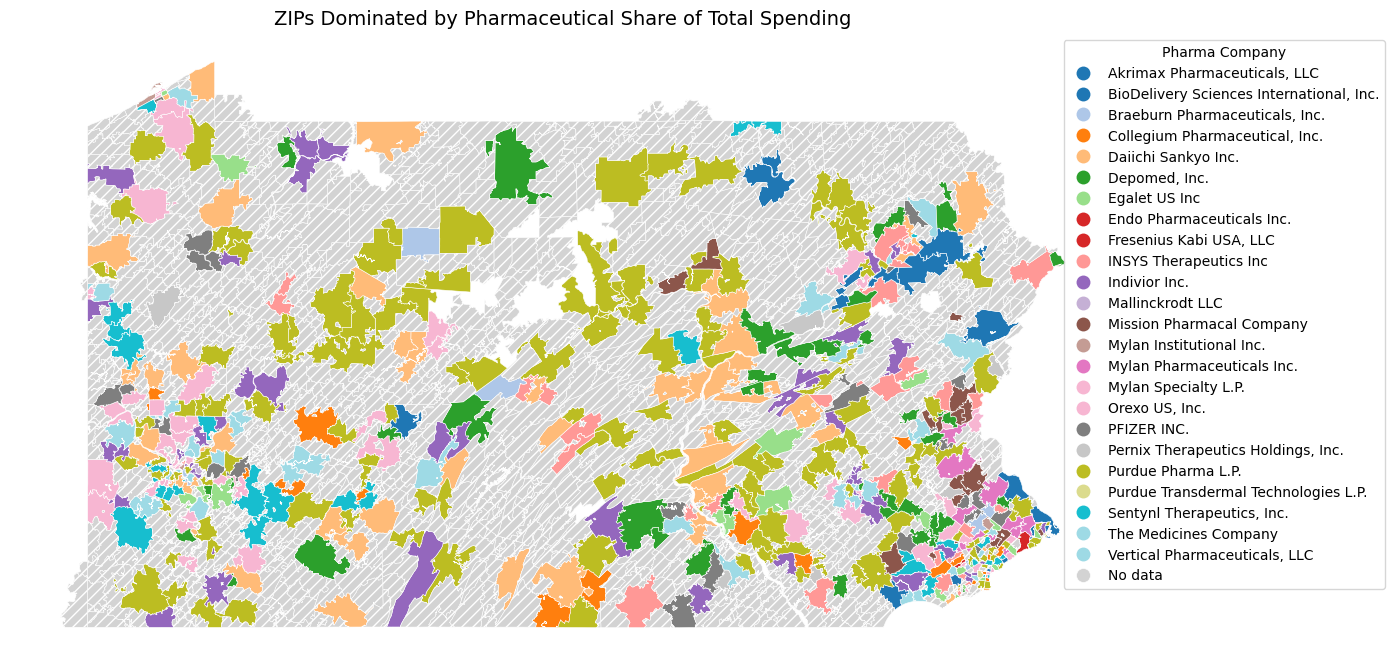

In [ ]:
df_zips_clean = df_zips[["doctor_id", "zip"]].rename(columns={
    "doctor_id": "zip_doctor_id",
    "zip": "Recipient_Zip_Code"
})

df_network_merged = df_network.merge(
    df_zips_clean,
    left_on="Covered_Recipient_NPI",
    right_on="zip_doctor_id",
    how="left"
)

company_totals = (
    df_network_merged.groupby("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name")["Total_Opioid_Payments"]
    .sum()
    .rename("company_total")
)
if "company_total" not in df_network_merged.columns:
    df_network_merged = df_network_merged.merge(
        company_totals,
        left_on="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name",
        right_index=True
    )


df_network_merged["zip_share"] = df_network_merged["Total_Opioid_Payments"] / df_network_merged["company_total"]

zip_company_share = (
    df_network_merged.groupby(["Recipient_Zip_Code", "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"])["zip_share"]
    .sum()
    .reset_index()
)

zip_top_company = (
    zip_company_share.sort_values(["Recipient_Zip_Code", "zip_share"], ascending=[True, False])
    .drop_duplicates(subset="Recipient_Zip_Code")
)

zip_top_company["Recipient_Zip_Code"] = zip_top_company["Recipient_Zip_Code"].astype(str).str.zfill(5)
zip_dominance_map = zip_shapes.merge(zip_top_company, left_on="zip", right_on="Recipient_Zip_Code", how="left")

fig, ax = plt.subplots(figsize=(14, 10))
zip_dominance_map.plot(
    column="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name",
    cmap="tab20",
    linewidth=0.4,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
leg.set_title("Pharma Company")

plt.title("ZIPs Dominated by Pharmaceutical Share of Total Spending", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()
fig.savefig("zip_dominance_map.jpg", format="jpg", dpi=300, bbox_inches="tight")


In [322]:
zip_dominance_counts = zip_top_company["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].value_counts()
print(zip_dominance_counts)

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name
Purdue Pharma L.P.                          174
Indivior Inc.                                55
Daiichi Sankyo Inc.                          51
Orexo US, Inc.                               43
INSYS Therapeutics Inc                       42
Sentynl Therapeutics, Inc.                   36
Depomed, Inc.                                35
Vertical Pharmaceuticals, LLC                33
PFIZER INC.                                  27
Mission Pharmacal Company                    21
Egalet US Inc                                14
Collegium Pharmaceutical, Inc.               13
BioDelivery Sciences International, Inc.     12
Mylan Specialty L.P.                         11
Akrimax Pharmaceuticals, LLC                 11
Mylan Institutional Inc.                      8
Pernix Therapeutics Holdings, Inc.            8
The Medicines Company                         6
Mylan Pharmaceuticals Inc.                    6
Braeburn Pharmaceuticals, 

In [323]:
top_zip_targets = zip_company_share.sort_values("zip_share", ascending=False).head(10)
print(top_zip_targets)


     Recipient_Zip_Code  \
2221              19104   
2234              19107   
317               15221   
1926              19020   
1816              18976   
1844              19002   
2478              19178   
1836              19001   
990               17055   
2019              19044   

     Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name  zip_share  
2221               Purdue Transdermal Technologies L.P.              1.000000  
2234                            Fresenius Kabi USA, LLC              1.000000  
317                                    Mallinckrodt LLC              1.000000  
1926                            Fresenius Kabi USA, LLC              1.000000  
1816                     Braeburn Pharmaceuticals, Inc.              0.814552  
1844                     Braeburn Pharmaceuticals, Inc.              0.814552  
2478                           Mylan Institutional Inc.              0.734753  
1836                         Mylan Pharmaceuticals Inc.       

In [ ]:
df_network["Covered_Recipient_NPI"] = df_network["Covered_Recipient_NPI"].astype(str).str.strip().str.zfill(10)
df_prescribers["Prscrbr_NPI"] = df_prescribers["Prscrbr_NPI"].astype(str).str.strip().str.zfill(10)

df_network = df_network.merge(
    df_prescribers[["Prscrbr_NPI", "Prscrbr_Type"]],
    left_on="Covered_Recipient_NPI",
    right_on="Prscrbr_NPI",
    how="left"
)

company_specialty = (
    df_network.groupby(["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"])
    ["Total_Opioid_Payments"]
    .sum()
    .reset_index()
)

company_totals = company_specialty.groupby("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name")["Total_Opioid_Payments"].sum().rename("company_total")
company_specialty = company_specialty.merge(company_totals, on="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name")
company_specialty["specialty_share"] = company_specialty["Total_Opioid_Payments"] / company_specialty["company_total"]


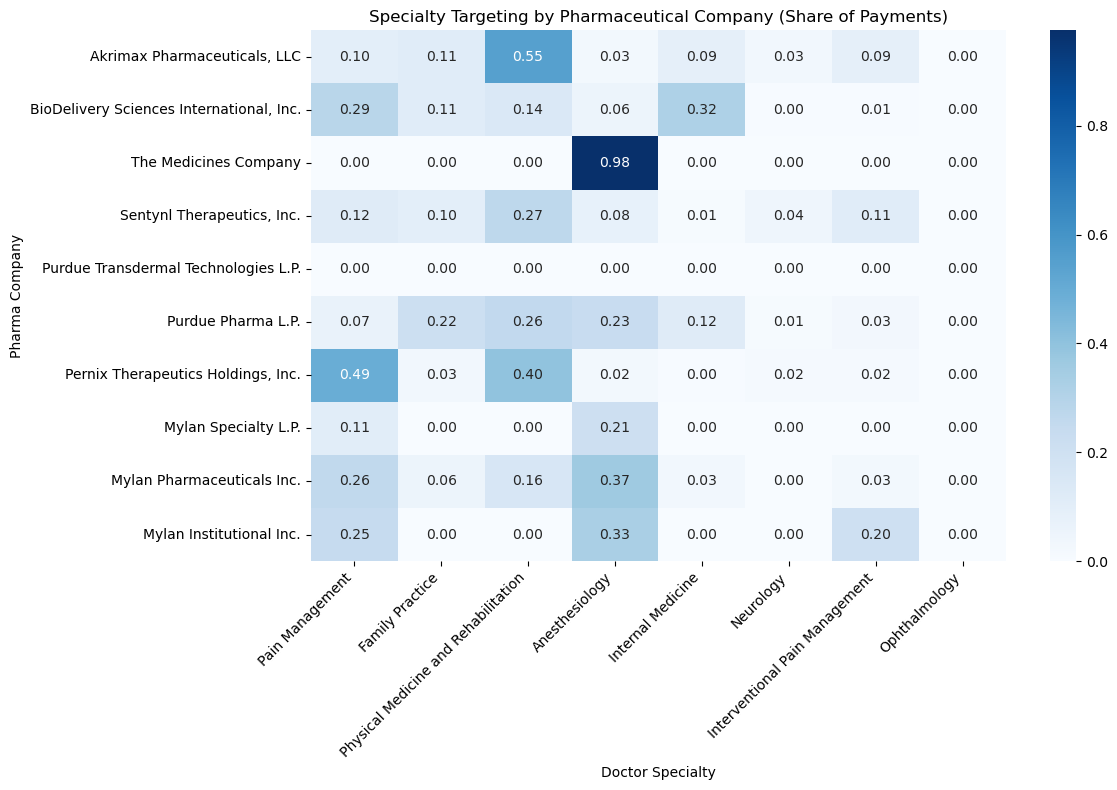

Prscrbr_Type
Pediatric Medicine    1
Name: count, dtype: int64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = company_specialty.pivot(
    index="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name",
    columns="Prscrbr_Type",
    values="specialty_share"
).fillna(0)

top_companies = heatmap_data.sum(axis=1).sort_values(ascending=False).head(10).index
top_specialties = heatmap_data.sum(axis=0).sort_values(ascending=False).head(8).index
heatmap_filtered = heatmap_data.loc[top_companies, top_specialties]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_filtered, annot=True, fmt=".2f", cmap="Blues")
plt.title("Specialty Targeting by Pharmaceutical Company (Share of Payments)")
plt.ylabel("Pharma Company")
plt.xlabel("Doctor Specialty")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_network[
    df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"] == "Purdue Transdermal Technologies L.P."
]["Prscrbr_Type"].value_counts()


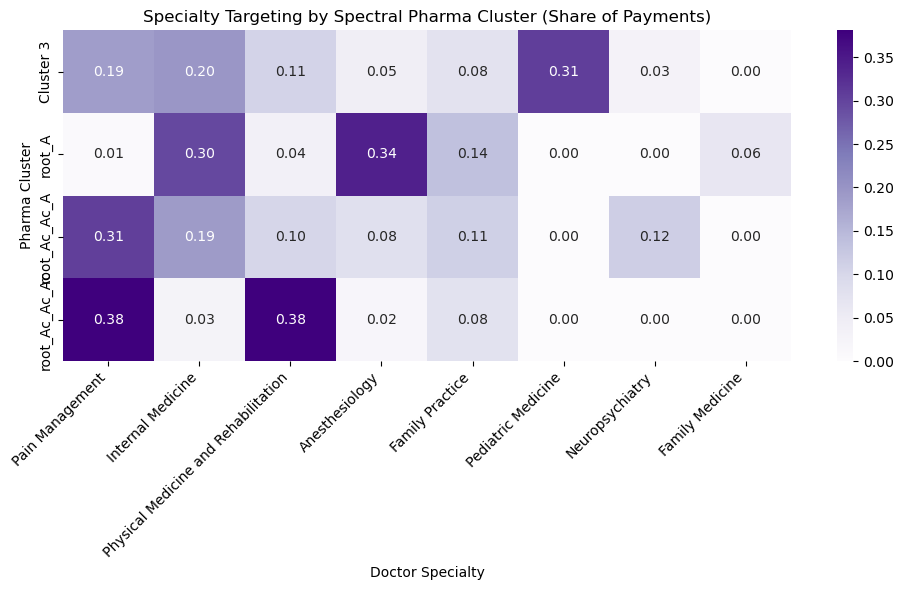

In [ ]:
company_to_cluster = {}
for partition in final_partitions:
    cluster_label = cluster_name_map.get(partition["name"], partition["name"])
    for company in partition["companies"]:
        company_to_cluster[company] = cluster_label

company_specialty["cluster"] = company_specialty["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].map(company_to_cluster)

company_specialty = company_specialty.dropna(subset=["cluster"])

cluster_specialty = (
    company_specialty.groupby(["cluster", "Prscrbr_Type"])["Total_Opioid_Payments"]
    .sum()
    .reset_index()
)

cluster_totals = cluster_specialty.groupby("cluster")["Total_Opioid_Payments"].sum().rename("cluster_total")
cluster_specialty = cluster_specialty.merge(cluster_totals, on="cluster")
cluster_specialty["specialty_share"] = cluster_specialty["Total_Opioid_Payments"] / cluster_specialty["cluster_total"]

import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data_cluster = cluster_specialty.pivot(
    index="cluster",
    columns="Prscrbr_Type",
    values="specialty_share"
).fillna(0)

top_specialties = heatmap_data_cluster.sum(axis=0).sort_values(ascending=False).head(8).index
heatmap_filtered_cluster = heatmap_data_cluster[top_specialties]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_filtered_cluster, annot=True, fmt=".2f", cmap="Purples")
plt.title("Specialty Targeting by Spectral Pharma Cluster (Share of Payments)")
plt.xlabel("Doctor Specialty")
plt.ylabel("Pharma Cluster")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/var/folders/0n/fdwzy91j2j38zqkrjnq3yc040000gn/T/ipykernel_9959/1281595018.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_specialty_filtered["cluster"] = company_specialty_filtered["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].map(company_to_cluster)


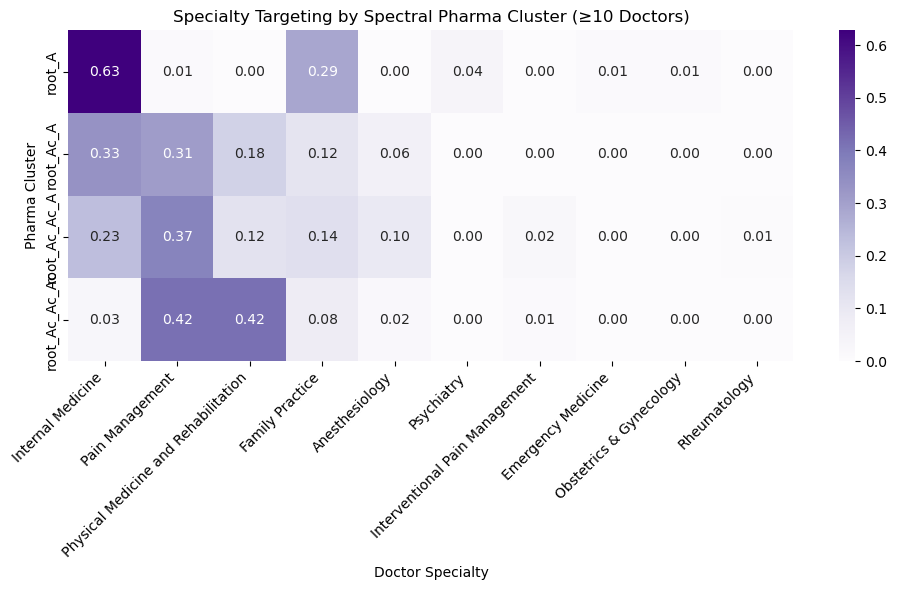

In [ ]:

if "doctor_count" in company_specialty.columns:
    company_specialty = company_specialty.drop(columns=["doctor_count"])

doctor_counts = df_network.groupby(
    ["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"]
)["Covered_Recipient_NPI"].nunique().rename("doctor_count").reset_index()

company_specialty = company_specialty.merge(
    doctor_counts,
    on=["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"]
)

company_specialty_filtered = company_specialty[company_specialty["doctor_count"] >= 10]

company_specialty_filtered["cluster"] = company_specialty_filtered["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].map(company_to_cluster)
company_specialty_filtered = company_specialty_filtered.dropna(subset=["cluster"])

cluster_specialty_filtered = (
    company_specialty_filtered
    .groupby(["cluster", "Prscrbr_Type"])["Total_Opioid_Payments"]
    .sum()
    .reset_index()
)

cluster_totals_filtered = cluster_specialty_filtered.groupby("cluster")["Total_Opioid_Payments"].sum().rename("cluster_total")
cluster_specialty_filtered = cluster_specialty_filtered.merge(cluster_totals_filtered, on="cluster")
cluster_specialty_filtered["specialty_share"] = cluster_specialty_filtered["Total_Opioid_Payments"] / cluster_specialty_filtered["cluster_total"]

import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data_filtered = cluster_specialty_filtered.pivot(
    index="cluster",
    columns="Prscrbr_Type",
    values="specialty_share"
).fillna(0)

top_specialties_filtered = heatmap_data_filtered.sum(axis=0).sort_values(ascending=False).head(10).index
heatmap_filtered = heatmap_data_filtered[top_specialties_filtered]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_filtered, annot=True, fmt=".2f", cmap="Purples")
plt.title("Specialty Targeting by Spectral Pharma Cluster (≥10 Doctors)")
plt.xlabel("Doctor Specialty")
plt.ylabel("Pharma Cluster")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


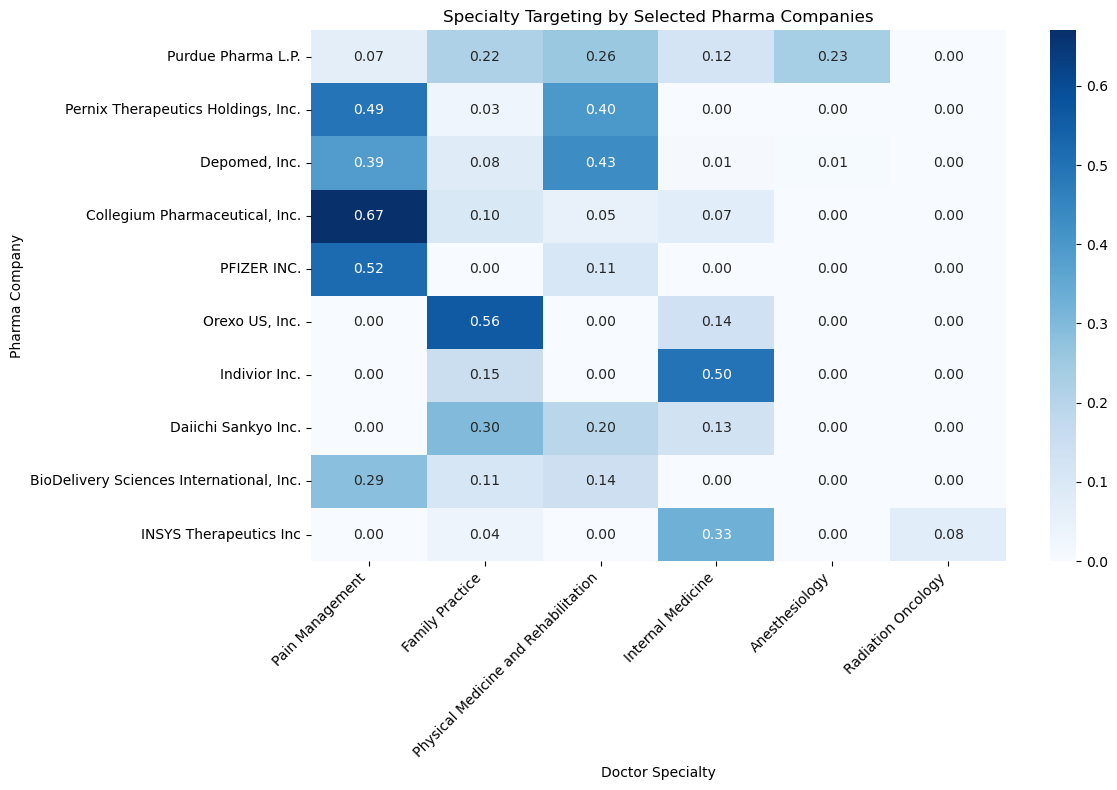

In [ ]:
if "doctor_count" in company_specialty.columns:
    company_specialty = company_specialty.drop(columns=["doctor_count"])

doctor_counts = df_network.groupby(
    ["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"]
)["Covered_Recipient_NPI"].nunique().rename("doctor_count").reset_index()

company_specialty = company_specialty.merge(
    doctor_counts,
    on=["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name", "Prscrbr_Type"]
)
company_specialty_filtered = company_specialty[company_specialty["doctor_count"] >= 20]

heatmap_data_company = company_specialty_filtered.pivot(
    index="Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name",
    columns="Prscrbr_Type",
    values="specialty_share"
).fillna(0)

top_companies = heatmap_data_company.sum(axis=1).sort_values(ascending=False).head(10).index
top_specialties = heatmap_data_company.sum(axis=0).sort_values(ascending=False).head(6).index
heatmap_filtered_company = heatmap_data_company.loc[top_companies, top_specialties]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_filtered_company, annot=True, fmt=".2f", cmap="Blues")
plt.title("Specialty Targeting by Selected Pharma Companies")
plt.xlabel("Doctor Specialty")
plt.ylabel("Pharma Company")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

min_doctors = 30
doctor_counts = df_network.groupby("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name")["Covered_Recipient_NPI"].nunique()
valid_companies = doctor_counts[doctor_counts >= min_doctors].index

filtered_df = df_network[df_network["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].isin(valid_companies)]

G = nx.Graph()
pharma_nodes = filtered_df["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"].unique()
doctor_nodes = filtered_df["Covered_Recipient_NPI"].unique()

G.add_nodes_from(pharma_nodes, bipartite=0)
G.add_nodes_from(doctor_nodes, bipartite=1)

for _, row in filtered_df.iterrows():
    G.add_edge(row["Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name"], row["Covered_Recipient_NPI"], weight=row.get("Total_Amount_of_Payment_USDollars", 1.0))

pharma_nodes = [n for n, d in G.nodes(data=True) if d["bipartite"] == 0]
doctor_nodes = [n for n, d in G.nodes(data=True) if d["bipartite"] == 1]

pharma_idx = {n: i for i, n in enumerate(pharma_nodes)}
doctor_idx = {n: i for i, n in enumerate(doctor_nodes)}

B = np.zeros((len(pharma_nodes), len(doctor_nodes)))

for u, v, data in G.edges(data=True):
    if G.nodes[u]["bipartite"] == 0:  # u = pharma, v = doctor
        i, j = pharma_idx[u], doctor_idx[v]
    else:  # u = doctor, v = pharma
        i, j = pharma_idx[v], doctor_idx[u]
    B[i, j] = data.get("weight", 1.0)
row_sums = B.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1e-7
B_normalized = B / row_sums
a = np.ones(len(doctor_nodes))
h = np.ones(len(pharma_nodes))

for _ in range(100):
    a = B_normalized.T @ h
    h = B_normalized @ a
    a /= np.linalg.norm(a)
    h /= np.linalg.norm(h)

authority_df_norm = pd.DataFrame({
    "doctor_id": doctor_nodes,
    "authority_score_normalized": a
})

hub_df_norm = pd.DataFrame({
    "pharma_company": pharma_nodes,
    "hub_score_normalized": h
})

In [310]:
print(hub_df_norm)

                              pharma_company  hub_score_normalized
0   BioDelivery Sciences International, Inc.              0.316804
1             Braeburn Pharmaceuticals, Inc.              0.136414
2             Collegium Pharmaceutical, Inc.              0.207576
3                        Daiichi Sankyo Inc.              0.237019
4                              Depomed, Inc.              0.116133
5                              Egalet US Inc              0.333896
6                     INSYS Therapeutics Inc              0.140845
7                              Indivior Inc.              0.047654
8                       Mylan Specialty L.P.              0.043476
9                             Orexo US, Inc.              0.080400
10                               PFIZER INC.              0.247318
11        Pernix Therapeutics Holdings, Inc.              0.262497
12                        Purdue Pharma L.P.              0.087228
13                Sentynl Therapeutics, Inc.              0.56

In [311]:
top20_doctors = authority_df_norm.sort_values("authority_score_normalized", ascending=False).head(20)
print(top20_doctors)

      doctor_id  authority_score_normalized
119  1902901135                    0.157755
63   1518056472                    0.156211
52   1427056555                    0.154601
9    1083614192                    0.143239
38   1285847699                    0.142890
267  1326023888                    0.134844
11   1104856657                    0.128503
103  1780767319                    0.127995
90   1649341983                    0.126985
92   1669481578                    0.124566
87   1629082763                    0.123580
18   1124227103                    0.121504
916  1437166816                    0.117455
120  1922196724                    0.116435
291  1427011006                    0.112076
114  1861462798                    0.106647
390  1861710980                    0.104836
229  1134276736                    0.104836
47   1407267099                    0.103455
8    1053434399                    0.102232


In [ ]:

authority_df_norm["doctor_id"] = authority_df_norm["doctor_id"].astype(float).astype(int).astype(str)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str)

print("Unique doctor_ids in authority_df_norm:", authority_df_norm["doctor_id"].unique()[:10])
print("Unique doctor_ids in df_zips:", df_zips["doctor_id"].unique()[:10])
merged_check = authority_df_norm.merge(df_zips, on="doctor_id", how="inner")
print("Merged rows:", len(merged_check))
print(merged_check.head())

Unique doctor_ids in authority_df_norm: ['1003022500' '1013295856' '1023174034' '1023245883' '1033111778'
 '1033177357' '1043292477' '1053351924' '1053434399' '1083614192']
Unique doctor_ids in df_zips: ['1689629438' '1275584807' '1245205608' '1477841468' '1619948544'
 '1083051841' '1760431548' '1326215690' '1801987961' '1669477915']
Merged rows: 3323
    doctor_id  authority_score_normalized    zip
0  1003022500                    0.033806  19090
1  1013295856                    0.025178  15212
2  1013295856                    0.025178  19406
3  1013295856                    0.025178  19103
4  1023174034                    0.027761  19104


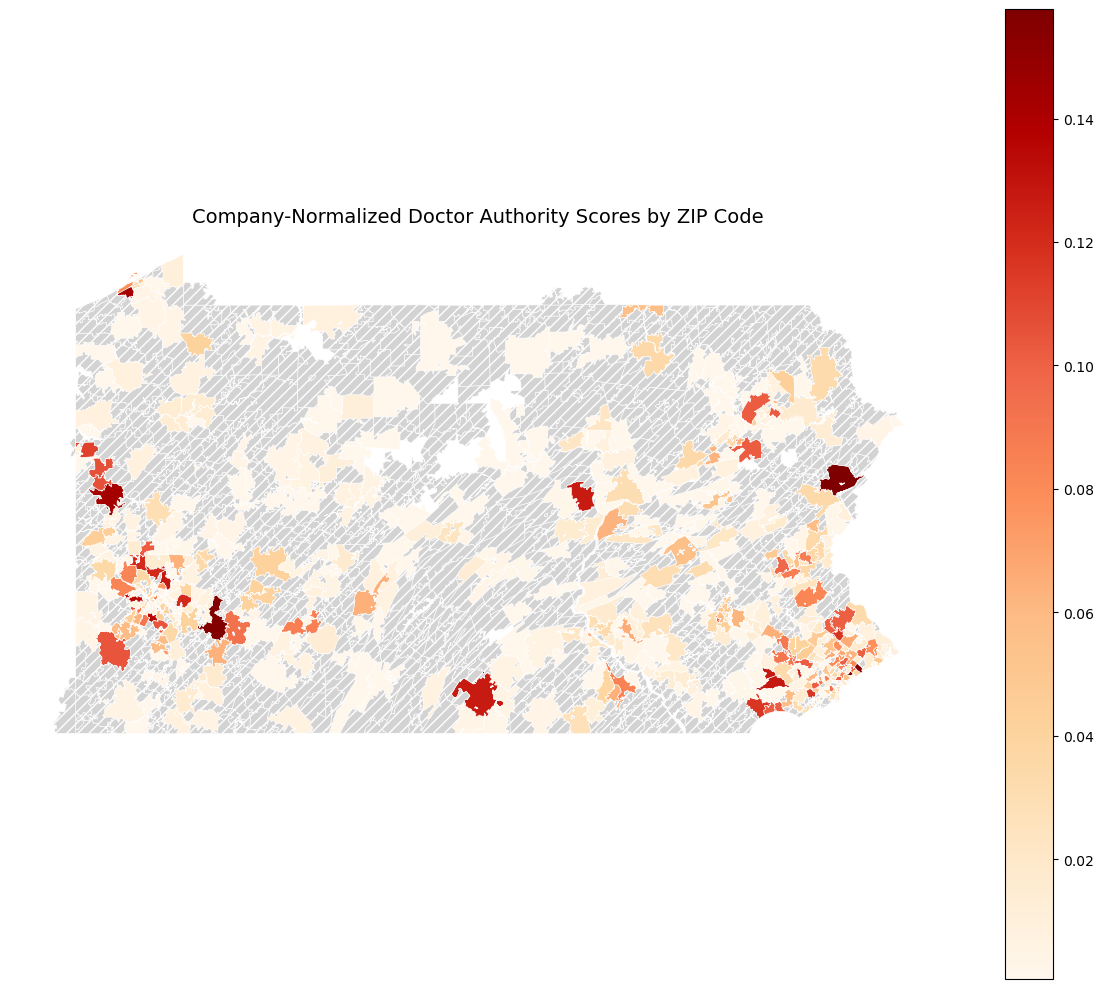

In [ ]:

authority_df_norm["doctor_id"] = (
    authority_df_norm["doctor_id"]
    .astype(float)
    .astype(int)
    .astype(str)
    .str.strip()
    .str.zfill(10)
)
df_zips["doctor_id"] = df_zips["doctor_id"].astype(str).str.strip().str.zfill(10)
authority_zips_norm = authority_df_norm.merge(df_zips, on="doctor_id", how="left")
zip_auth_summary_norm = (
    authority_zips_norm.groupby("zip")["authority_score_normalized"]
    .max()
    .reset_index()
)
zip_auth_summary_norm["zip"] = zip_auth_summary_norm["zip"].astype(str).str.zfill(5)
zip_auth_map_norm = zip_shapes.merge(zip_auth_summary_norm, on="zip", how="left")
fig, ax = plt.subplots(figsize=(12, 10))
zip_auth_map_norm.plot(
    column="authority_score_normalized",
    cmap="OrRd",
    linewidth=0.4,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

plt.title("Company-Normalized Doctor Authority Scores by ZIP Code", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()
fig.savefig("authoritiesnormalized.jpg", format="jpg", dpi=300, bbox_inches="tight")


In [210]:
top200_doctors = authority_df_norm.sort_values("authority_score_normalized", ascending=False).head(200)

top200_named = top200_doctors.merge(
    df_payments[
        [
            "Covered_Recipient_NPI",
            "Covered_Recipient_First_Name",
            "Covered_Recipient_Middle_Name",
            "Covered_Recipient_Last_Name",
            "Covered_Recipient_Specialty_1"
        ]
    ].drop_duplicates(subset="Covered_Recipient_NPI", keep="first"),
    left_on="doctor_id",
    right_on="Covered_Recipient_NPI",
    how="left"
)
top200_named.to_csv("top200_doctors_authority_scores.csv", index=False)


In [ ]:
from networkx.algorithms import bipartite
import pandas as pd

clust_dict = {n: bipartite.cluster.clustering(G, [n]).get(n, 0.0) for n in pharma_nodes}

clust_df = pd.DataFrame({
    "pharma_company": list(clust_dict.keys()),
    "clustering_coeff": list(clust_dict.values())
}).sort_values("clustering_coeff", ascending=False).reset_index(drop=True)

print(clust_df)

                              pharma_company  clustering_coeff
0         Pernix Therapeutics Holdings, Inc.          0.111663
1                        Daiichi Sankyo Inc.          0.110027
2                                PFIZER INC.          0.107856
3             Collegium Pharmaceutical, Inc.          0.105035
4                              Egalet US Inc          0.101591
5   BioDelivery Sciences International, Inc.          0.100664
6                              Depomed, Inc.          0.083016
7                         Purdue Pharma L.P.          0.074872
8                 Sentynl Therapeutics, Inc.          0.070294
9              Vertical Pharmaceuticals, LLC          0.065831
10                    INSYS Therapeutics Inc          0.050710
11                Mylan Pharmaceuticals Inc.          0.049204
12                            Orexo US, Inc.          0.035354
13                  Mylan Institutional Inc.          0.035001
14                             Indivior Inc.          0

In [233]:
print(len(pharma_nodes))


15
